In [19]:
import numpy as np
#import numpy.ma as ma
from uncertainties import ufloat, unumpy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

In [20]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})

#params = {'text.latex.preamble':[r'\usepackage{siunitx}',
#                                 r'\usepackage{amsmath}',
#                                 r'\usepackage{physics}',
#                                 r'\usepackage{sfmath}',
#                                 r'\sisetup{detect-all=true}']}

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}']}
plt.rcParams.update(params)

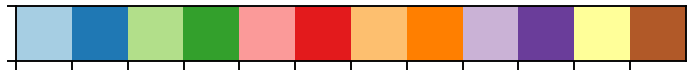

In [21]:
sns.set_context('talk')
sns.palplot(sns.color_palette("Paired"))

# Constants

In [22]:
C = 299792458 # Speed of light in [m/s]
H = 6.62607015E-34 # Planck's constant [Js]
HBAR = H/(2*np.pi) # Planck's constant [Js]
KB = 1.380649E-23 # Boltzmann constant [J/K]
E0 = ufloat(8.8541878128, 0.0000000013)*1E-12 # Vacuum electric permittivity (epsilon_0) [F/m]
BOHR = ufloat(5.29177210903, 0.00000000080)*1E-11 # Bohr radius [m]

# Functions

In [23]:
# Trap power lock without additional attenuators
def power_lock_trap(V):
    # Linear fit slope
    m = ufloat(258.915611, 0.66058672)
    
    # Linear fit intercept
    b = ufloat(78.0872501, 2.84702705)
    
    # Returns power in [uW]
    return m*V + b

def power_lock_trap_ND513A(V):
    # Linear fit slope
    m = ufloat(14.1992971, 0.01643145)
    
    # Linear fit intercept
    b = ufloat(4.41319911, 0.08775840)
    
    # Returns power in [uW]
    return m*V + b

# Lifetime plot

In [24]:
# No dimple lifetime
lifetime_no_dimple = np.mean([ufloat(12.968, 0.609), ufloat(11.877, 0.658), ufloat(13.832, 1.021)])
lifetime_no_dimple_avg = lifetime_no_dimple.nominal_value
lifetime_no_dimple_std = lifetime_no_dimple.std_dev

In [25]:
data = pd.read_excel('dimple_84Sr-measurements.xlsx', sheet_name='Lifetime')

data['Power'] = 0
for idx, row in data.iterrows():
    P = 0
    V = row['Dimple set point [V]']
    if row['ND513A?']:
        P = power_lock_trap_ND513A(V)
    
    elif ~row['ND513A?']:
        P = power_lock_trap(V)
        
    else:
        print('Error!')
    
    data.at[idx,'Power'] = P

data['Power_avg'] = unumpy.nominal_values(data['Power'])
data['Power_unc'] = unumpy.std_devs(data['Power'])

data.drop(columns='Power', inplace=True)

In [26]:
data_agg = data.groupby(by=['Power_avg'], as_index=False).agg({'Power_unc':['first'],
                                                               'Lifetime [s]':[np.mean, np.std]})

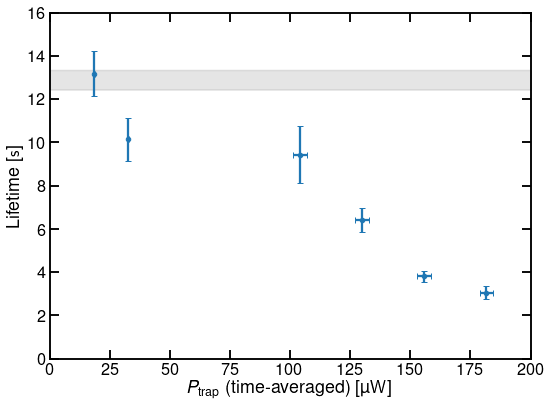

In [48]:
x_no_dimple = np.linspace(-10, 200, 1000)

# Measured dimple lifetime
xdata = data_agg['Power_avg']
xerr = data_agg['Power_unc','first']

ydata = data_agg['Lifetime [s]','mean']
yerr = data_agg['Lifetime [s]','std']

plt.figure(figsize=(8,6))
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, fmt='.', capsize=3, zorder=2)

plt.fill_between(x_no_dimple,
                 lifetime_no_dimple_avg+lifetime_no_dimple_std,
                 lifetime_no_dimple_avg-lifetime_no_dimple_std,
                 color='grey', alpha=0.2, zorder=0)

# Tick settings
ax = plt.gca()
#ax.tick_params(direction='in', axis='both', which='both', bottom=True, top=True, left=True, right=True, length=5)
ax.tick_params(direction='in', axis='both', which='both', bottom=True, top=True, left=True, right=True)

# Axis limits
plt.xlim((0, 200))
plt.ylim((0, 16))

# Axes labels
plt.xlabel(r'$P_{\rm{trap}}$ (time-averaged) [$\si{\uW}$]')
plt.ylabel(r'Lifetime [$\si{\second}$]')

plt.tight_layout()

plt.savefig('dimple-84Sr_lifetime.pdf', bbox_inches='tight')

plt.show()

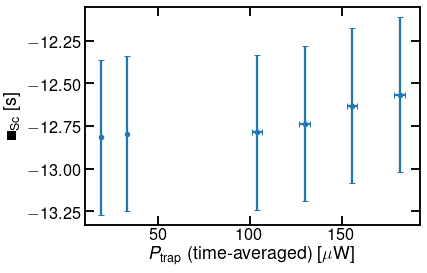

In [28]:
# Measured dimple lifetime
xdata = data_agg['Power_avg']
xerr = data_agg['Power_unc','first']

ydata = data_agg['Lifetime [s]','mean']
yerr = data_agg['Lifetime [s]','std']

tau_total = unumpy.uarray(ydata, yerr)
tau_bg = 1/lifetime_no_dimple

G_sc = 1/tau_total - 1/tau_bg

x_no_dimple = np.linspace(0, 200)

# Measured dimple lifetime
xdata = data_agg['Power_avg']
xerr = data_agg['Power_unc','first']

ydata = unumpy.nominal_values(G_sc)
yerr = unumpy.std_devs(G_sc)

plt.figure()
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, fmt='.', capsize=3)

# Tick settings
ax = plt.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',direction='in')

# Axes labels
plt.xlabel(r'$P_{\rm{trap}}$ (time-averaged) [$\rm{{\mu}W}$]')
plt.ylabel(r'$\Gamma_{\rm{Sc}}$ [s]')

plt.show()